In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Step 1: Load Data
data = pd.read_csv("multinomial_logistic_results.csv")

# Adding additional covariates
data['patient_weight'] = np.random.normal(70, 10, len(data))  # Mock data for weight
data['comorbidity_ASCV'] = np.random.choice([0, 1], len(data))
data['comorbidity_HF'] = np.random.choice([0, 1], len(data))
data['comorbidity_CKD'] = np.random.choice([0, 1], len(data))
data['eGFR'] = np.random.normal(90, 15, len(data))  # Mock data for eGFR

# Select features and target
features = [
    'race_ethnicity', 'sex', 'marital_status', 'patient_regional_location', 'hba1c_last_value',
    'diabetes_duration_2023', 'Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
    'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1', 'Last_Med_TZD',
    'patient_weight', 'comorbidity_ASCV', 'comorbidity_HF', 'comorbidity_CKD', 'eGFR'
]
target = 'hba1c_last_value'

# Generate sequential data (mock example assuming 10 timesteps per patient)
sequence_length = 10
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[features].iloc[i:i + sequence_length].values)
    y.append(data[target].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Step 2: Define Dataset and DataLoader
class HbA1CDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Define RNN Model (GRU, LSTM, or Bi-LSTM)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, rnn_type="LSTM"):
        super(RNNModel, self).__init__()
        self.rnn_type = rnn_type
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == "Bi-LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported RNN type")
        self.fc = nn.Linear(hidden_dim * (2 if rnn_type == "Bi-LSTM" else 1), output_dim)

    def forward(self, x):
        if self.rnn_type in ["LSTM", "Bi-LSTM"]:
            _, (hn, _) = self.rnn(x)
        else:
            _, hn = self.rnn(x)
        hn = hn[-1]  # Use the last hidden state
        output = self.fc(hn)
        return output

# Step 4: Training and Evaluation
def train_and_evaluate(X, y, rnn_type="LSTM", num_epochs=10, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    all_mae, all_mse = [], []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"Fold {fold + 1}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dataset = HbA1CDataset(X_train, y_train)
        test_dataset = HbA1CDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Model, Loss, Optimizer
        model = RNNModel(input_dim=X.shape[2], hidden_dim=64, output_dim=1, num_layers=2, rnn_type=rnn_type).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training
        model.train()
        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        # Evaluation
        model.eval()
        predictions, true_values = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                predictions.extend(outputs.cpu().numpy())
                true_values.extend(targets.cpu().numpy())
        
        mae = mean_absolute_error(true_values, predictions)
        mse = mean_squared_error(true_values, predictions)
        all_mae.append(mae)
        all_mse.append(mse)

        print(f"Fold {fold + 1} - MAE: {mae:.4f}, MSE: {mse:.4f}")

    print(f"Average MAE: {np.mean(all_mae):.4f}, Average MSE: {np.mean(all_mse):.4f}")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run training and evaluation
train_and_evaluate(X, y, rnn_type="LSTM", num_epochs=10)


Fold 1


C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.4454
Epoch 2/10, Loss: 15.8134
Epoch 3/10, Loss: 0.3622
Epoch 4/10, Loss: 7.3847
Epoch 5/10, Loss: 0.6454
Epoch 6/10, Loss: 0.5190
Epoch 7/10, Loss: 0.5443
Epoch 8/10, Loss: 4.2900
Epoch 9/10, Loss: 0.5922
Epoch 10/10, Loss: 0.5694
Fold 1 - MAE: 0.7208, MSE: 0.9541
Fold 2


C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.3179
Epoch 2/10, Loss: 0.5687
Epoch 3/10, Loss: 0.5066
Epoch 4/10, Loss: 0.1735
Epoch 5/10, Loss: 0.0563
Epoch 6/10, Loss: 0.1593
Epoch 7/10, Loss: 0.1878
Epoch 8/10, Loss: 0.0999
Epoch 9/10, Loss: 0.4871
Epoch 10/10, Loss: 0.5023
Fold 2 - MAE: 0.7327, MSE: 1.0239
Fold 3
Epoch 1/10, Loss: 2.4324
Epoch 2/10, Loss: 0.4709
Epoch 3/10, Loss: 0.2576
Epoch 4/10, Loss: 7.8048
Epoch 5/10, Loss: 0.3490
Epoch 6/10, Loss: 0.6057
Epoch 7/10, Loss: 0.3839
Epoch 8/10, Loss: 0.6823
Epoch 9/10, Loss: 2.1624
Epoch 10/10, Loss: 0.1040
Fold 3 - MAE: 0.7031, MSE: 1.0072
Fold 4
Epoch 1/10, Loss: 0.4927
Epoch 2/10, Loss: 0.3998
Epoch 3/10, Loss: 0.0577
Epoch 4/10, Loss: 1.2717
Epoch 5/10, Loss: 0.5036
Epoch 6/10, Loss: 0.2781
Epoch 7/10, Loss: 0.1922
Epoch 8/10, Loss: 0.2182
Epoch 9/10, Loss: 0.2138
Epoch 10/10, Loss: 2.0016
Fold 4 - MAE: 0.7428, MSE: 1.0635
Fold 5
Epoch 1/10, Loss: 3.2847
Epoch 2/10, Loss: 0.5648
Epoch 3/10, Loss: 0.3489
Epoch 4/10, Loss: 0.3117
Epoch 5/10, Loss: 0.9185

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Load Data
data = pd.read_csv("multinomial_logistic_results.csv")

# Adding additional covariates
data['patient_weight'] = np.random.normal(70, 10, len(data))  # Mock data for weight
data['comorbidity_ASCV'] = np.random.choice([0, 1], len(data))
data['comorbidity_HF'] = np.random.choice([0, 1], len(data))
data['comorbidity_CKD'] = np.random.choice([0, 1], len(data))
data['eGFR'] = np.random.normal(90, 15, len(data))  # Mock data for eGFR

# Select features and target
features = [
    'race_ethnicity', 'sex', 'marital_status', 'patient_regional_location', 'hba1c_last_value',
    'diabetes_duration_2023', 'Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
    'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1', 'Last_Med_TZD',
    'patient_weight', 'comorbidity_ASCV', 'comorbidity_HF', 'comorbidity_CKD', 'eGFR'
]
target = 'hba1c_last_value'

# Generate sequential data (mock example assuming 10 timesteps per patient)
sequence_length = 10
X, y = [], []
for i in range(len(data) - sequence_length):
    X.append(data[features].iloc[i:i + sequence_length].values)
    y.append(data[target].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Step 2: Define Dataset and DataLoader
class HbA1CDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Define RNN Model (GRU, LSTM, or Bi-LSTM)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, rnn_type="LSTM"):
        super(RNNModel, self).__init__()
        self.rnn_type = rnn_type
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        elif rnn_type == "Bi-LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        else:
            raise ValueError("Unsupported RNN type")
        self.fc = nn.Linear(hidden_dim * (2 if rnn_type == "Bi-LSTM" else 1), output_dim)

    def forward(self, x):
        if self.rnn_type in ["LSTM", "Bi-LSTM"]:
            _, (hn, _) = self.rnn(x)
        else:
            _, hn = self.rnn(x)
        hn = hn[-1]  # Use the last hidden state
        output = self.fc(hn)
        return output

# Step 4: Training and Evaluation
def train_and_evaluate(X, y, rnn_type="LSTM", num_epochs=10, batch_size=32):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    all_mae, all_mse = [], []
    epoch_losses = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"Fold {fold + 1}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        train_dataset = HbA1CDataset(X_train, y_train)
        test_dataset = HbA1CDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Model, Loss, Optimizer
        model = RNNModel(input_dim=X.shape[2], hidden_dim=64, output_dim=1, num_layers=2, rnn_type=rnn_type).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Training
        model.train()
        fold_losses = []
        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            fold_losses.append(loss.item())
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

        epoch_losses.append(fold_losses)

        # Evaluation
        model.eval()
        predictions, true_values = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze()
                predictions.extend(outputs.cpu().numpy())
                true_values.extend(targets.cpu().numpy())
        
        mae = mean_absolute_error(true_values, predictions)
        mse = mean_squared_error(true_values, predictions)
        all_mae.append(mae)
        all_mse.append(mse)

        print(f"Fold {fold + 1} - MAE: {mae:.4f}, MSE: {mse:.4f}")

    print(f"Average MAE: {np.mean(all_mae):.4f}, Average MSE: {np.mean(all_mse):.4f}")

    # Plot the loss curve for each fold
    for fold, fold_losses in enumerate(epoch_losses):
        plt.plot(range(1, num_epochs+1), fold_losses, label=f"Fold {fold + 1}")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss per Fold')
    plt.legend()
    plt.show()

    # Plot MAE and MSE across folds
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, 6), all_mae)
    plt.xlabel('Fold')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE per Fold')

    plt.subplot(1, 2, 2)
    plt.bar(range(1, 6), all_mse)
    plt.xlabel('Fold')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE per Fold')
    plt.tight_layout()
    plt.show()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run training and evaluation
train_and_evaluate(X, y, rnn_type="LSTM", num_epochs=10)

In [40]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: C:\Users\rafif\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


Columns in the dataset: Index(['race_ethnicity', 'sex', 'marital_status', 'patient_regional_location',
       'hba1c_last_value', 'diabetes_duration_2023', 'Last_Med_MET',
       'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
       'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1',
       'Last_Med_GIP_GLP1', 'Last_Med_TZD', 'True_Medication', 'IPTW',
       'Propensity_Score_DPP4', 'Propensity_Score_GIP_GLP1',
       'Propensity_Score_GLP1', 'Propensity_Score_Insulin',
       'Propensity_Score_MET', 'Propensity_Score_Nothing',
       'Propensity_Score_SGLT2', 'Propensity_Score_SUL',
       'Propensity_Score_TZD', 'Propensity_Score_Triple+ therapy'],
      dtype='object')
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        14
           4  

C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

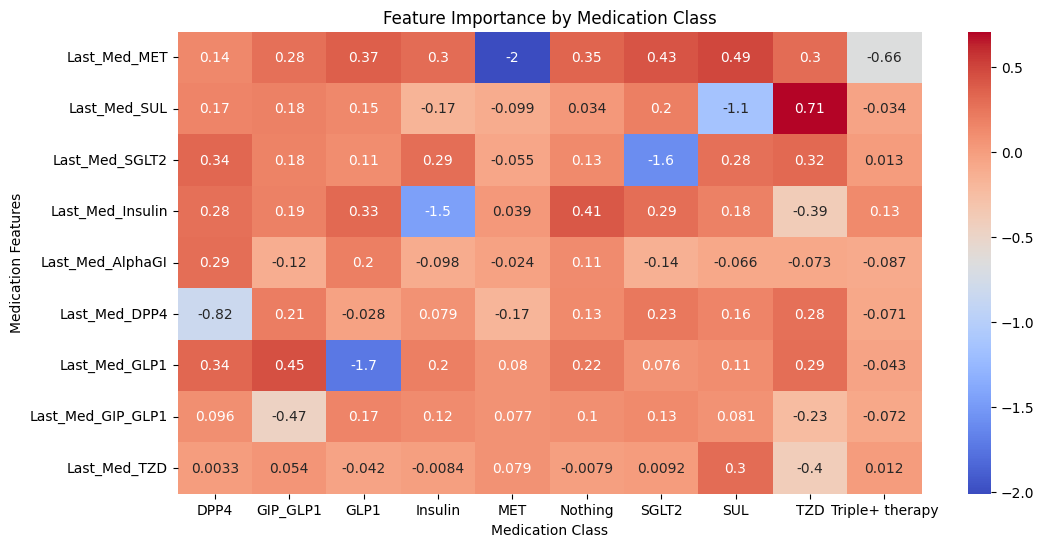

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('multinomial_logistic_results.csv')

# Check the column names for clarity
print("Columns in the dataset:", data.columns)

# Encode the target variable ('True_Medication' instead of 'Prescribing New Meds')
label_encoder = LabelEncoder()
data['True_Medication_Encoded'] = label_encoder.fit_transform(data['True_Medication'])

# Features and Target
# Assume the medication columns ('Last_Med_*') represent the last 6 months' medications
medication_columns = ['Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
                      'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1',
                      'Last_Med_TZD']
X = data[medication_columns]
y = data['True_Medication_Encoded']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (coefficients)
coefficients = pd.DataFrame(model.coef_, columns=medication_columns, index=label_encoder.classes_)
plt.figure(figsize=(12, 6))
sns.heatmap(coefficients.T, annot=True, cmap="coolwarm", cbar=True)
plt.title("Feature Importance by Medication Class")
plt.xlabel("Medication Class")
plt.ylabel("Medication Features")


plt.show()

In [42]:
print(data.columns)

Index(['race_ethnicity', 'sex', 'marital_status', 'patient_regional_location',
       'hba1c_last_value', 'diabetes_duration_2023', 'Last_Med_MET',
       'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
       'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1',
       'Last_Med_GIP_GLP1', 'Last_Med_TZD', 'True_Medication', 'IPTW',
       'Propensity_Score_DPP4', 'Propensity_Score_GIP_GLP1',
       'Propensity_Score_GLP1', 'Propensity_Score_Insulin',
       'Propensity_Score_MET', 'Propensity_Score_Nothing',
       'Propensity_Score_SGLT2', 'Propensity_Score_SUL',
       'Propensity_Score_TZD', 'Propensity_Score_Triple+ therapy',
       'True_Medication_Encoded'],
      dtype='object')


In [47]:
print([col for col in data.columns if 'Prescribing New Meds' in col])

[]


In [48]:
data.rename(columns={'actual_column_name': 'Prescribing New Meds'}, inplace=True)

In [49]:
|## Now we are going to use the RNN model for our dataset

SyntaxError: invalid syntax (3662829326.py, line 1)

In [50]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: C:\Users\rafif\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


Columns in the dataset: Index(['race_ethnicity', 'sex', 'marital_status', 'patient_regional_location',
       'hba1c_last_value', 'diabetes_duration_2023', 'Last_Med_MET',
       'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
       'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1',
       'Last_Med_GIP_GLP1', 'Last_Med_TZD', 'True_Medication', 'IPTW',
       'Propensity_Score_DPP4', 'Propensity_Score_GIP_GLP1',
       'Propensity_Score_GLP1', 'Propensity_Score_Insulin',
       'Propensity_Score_MET', 'Propensity_Score_Nothing',
       'Propensity_Score_SGLT2', 'Propensity_Score_SUL',
       'Propensity_Score_TZD', 'Propensity_Score_Triple+ therapy'],
      dtype='object')
Epoch 1/50


C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8560 - loss: 0.7768 - val_accuracy: 0.9498 - val_loss: 0.2987
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9473 - loss: 0.3137 - val_accuracy: 0.9498 - val_loss: 0.2907
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9473 - loss: 0.3031 - val_accuracy: 0.9498 - val_loss: 0.2881
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9465 - loss: 0.3061 - val_accuracy: 0.9498 - val_loss: 0.2859
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9470 - loss: 0.2986 - val_accuracy: 0.9498 - val_loss: 0.2852
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.3027 - val_accuracy: 0.9498 - val_loss: 0.2823
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9485 - loss: 0.2898 - val_accuracy: 0.9498 - val_loss: 0.2813
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9477 - loss: 0.2936 - val_accuracy: 0.9498 - val_

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


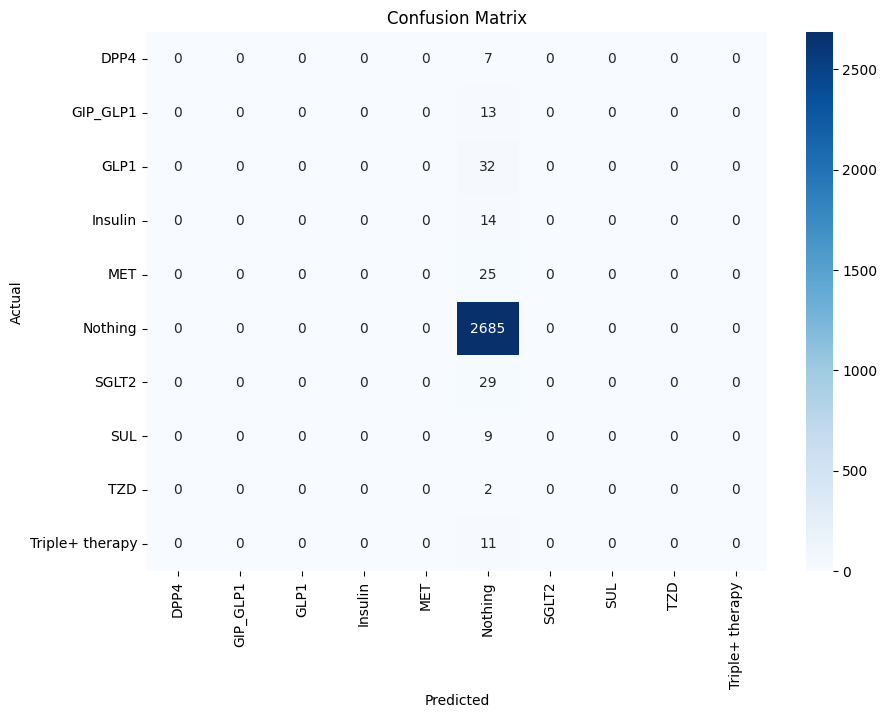

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load your dataset
data = pd.read_csv('multinomial_logistic_results.csv')

# Check the column names for clarity
print("Columns in the dataset:", data.columns)

# Encode the target variable ('True_Medication' instead of 'Prescribing New Meds')
label_encoder = LabelEncoder()
data['True_Medication_Encoded'] = label_encoder.fit_transform(data['True_Medication'])

# Features and Target
# Assume the medication columns ('Last_Med_*') represent the last 6 months' medications
medication_columns = ['Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
                      'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1',
                      'Last_Med_TZD']
X = data[medication_columns].values
y = data['True_Medication_Encoded'].values

# Reshape data for RNN input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (num_samples, timesteps=1, num_features)

# One-hot encode the target variable
y = to_categorical(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer (softmax for multiclass classification)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (coefficients not directly available in RNNs, but can be inferred from weights)
# Visualizing RNN weights could be complex, but it's possible to examine the learned features or neuron activations.


Epoch 1/50


C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7569 - loss: 1.0113 - val_accuracy: 0.9498 - val_loss: 0.3054
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9470 - loss: 0.3234 - val_accuracy: 0.9498 - val_loss: 0.2986
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9435 - loss: 0.3270 - val_accuracy: 0.9498 - val_loss: 0.2938
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9473 - loss: 0.3055 - val_accuracy: 0.9498 - val_loss: 0.2896
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9457 - loss: 0.3079 - val_accuracy: 0.9498 - val_loss: 0.2883
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9457 - loss: 0.3016 - val_accuracy: 0.9498 - val_loss: 0.2857
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9480 - loss: 0.2998 - val_accuracy: 0.9498 - val_loss: 0.2872
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9499 - loss: 0.2849 - val_accuracy: 0.9498 - val_

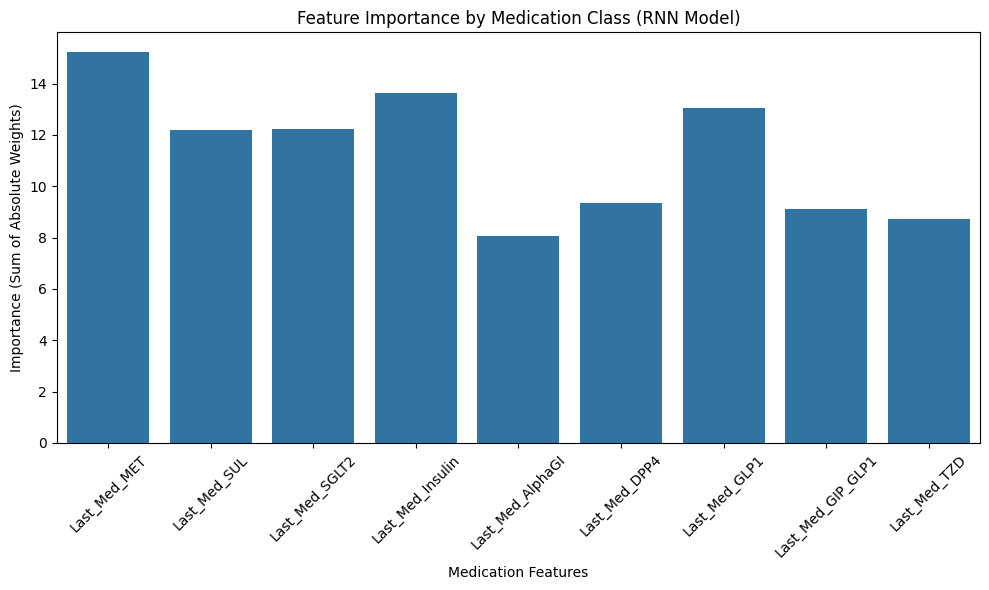

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load your dataset
data = pd.read_csv('multinomial_logistic_results.csv')

# Check the column names for clarity
print("Columns in the dataset:", data.columns)

# Encode the target variable ('True_Medication' instead of 'Prescribing New Meds')
label_encoder = LabelEncoder()
data['True_Medication_Encoded'] = label_encoder.fit_transform(data['True_Medication'])

# Features and Target
medication_columns = ['Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
                      'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1',
                      'Last_Med_TZD']
X = data[medication_columns].values
y = data['True_Medication_Encoded'].values

# Reshape data for RNN input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (num_samples, timesteps=1, num_features)

# One-hot encode the target variable
y = to_categorical(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer (softmax for multiclass classification)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Save the CSV of predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'True_Medication': label_encoder.inverse_transform(np.argmax(y_test, axis=1)),
    'Predicted_Medication': label_encoder.inverse_transform(y_pred_classes)
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

# Plot the accuracy and loss curves and save as PNG images
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy_plot.png')  # Save the accuracy plot

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('loss_plot.png')  # Save the loss plot

# Confusion Matrix and save as PNG
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix plot

# Display the plots (optional, if you want to see them immediately)
plt.show()

Epoch 1/50


C:\Users\rafif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7813 - loss: 0.9597 - val_accuracy: 0.9498 - val_loss: 0.3033
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.3254 - val_accuracy: 0.9498 - val_loss: 0.2913
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9449 - loss: 0.3198 - val_accuracy: 0.9498 - val_loss: 0.2871
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9457 - loss: 0.3091 - val_accuracy: 0.9498 - val_loss: 0.2852
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9464 - loss: 0.3033 - val_accuracy: 0.9498 - val_loss: 0.2862
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9441 - loss: 0.3110 - val_accuracy: 0.9498 - val_loss: 0.2852
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9494 - loss: 0.2904 - val_accuracy: 0.9498 - val_loss: 0.2858
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9463 - loss: 0.3032 - val_accuracy: 0.9498 - val_

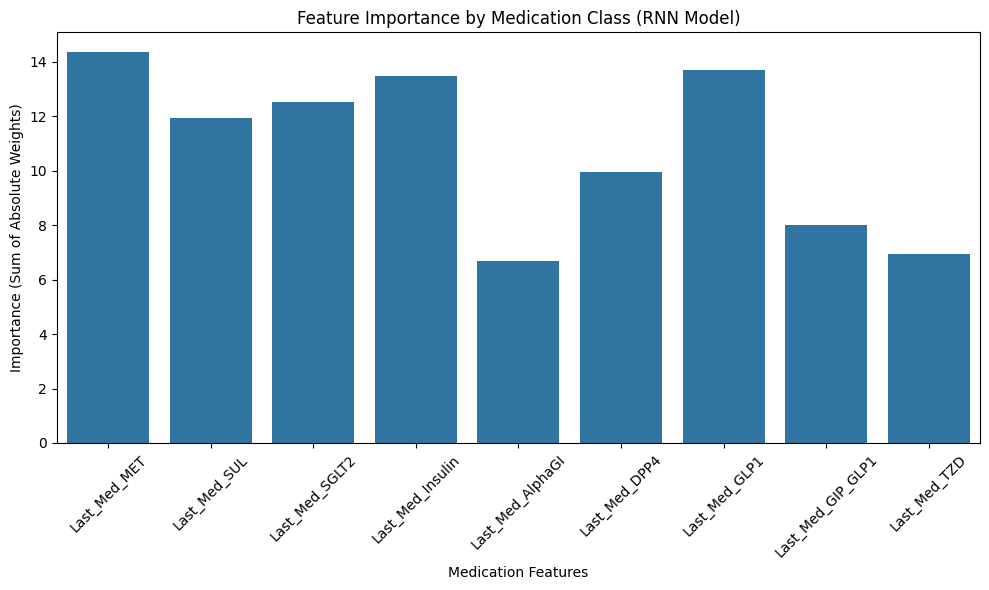

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('multinomial_logistic_results.csv')

# Encode the target variable ('True_Medication' instead of 'Prescribing New Meds')
label_encoder = LabelEncoder()
data['True_Medication_Encoded'] = label_encoder.fit_transform(data['True_Medication'])

# Features and Target
medication_columns = ['Last_Med_MET', 'Last_Med_SUL', 'Last_Med_SGLT2', 'Last_Med_Insulin',
                      'Last_Med_AlphaGI', 'Last_Med_DPP4', 'Last_Med_GLP1', 'Last_Med_GIP_GLP1',
                      'Last_Med_TZD']
X = data[medication_columns].values
y = data['True_Medication_Encoded'].values

# Reshape data for RNN input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # (num_samples, timesteps=1, num_features)

# One-hot encode the target variable
y = to_categorical(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))  # Output layer (softmax for multiclass classification)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Extract the weights of the SimpleRNN layer
rnn_weights = model.layers[0].get_weights()[0]  # First layer is SimpleRNN, get the weights (not bias)

# Calculate feature importance by taking the absolute value of the weights
feature_importance = np.abs(rnn_weights).sum(axis=1)  # Sum the absolute weights for each input feature

# Visualize the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=medication_columns, y=feature_importance)
plt.title("Feature Importance by Medication Class (RNN Model)")
plt.xlabel("Medication Features")
plt.ylabel("Importance (Sum of Absolute Weights)")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the feature importance plot
plt.savefig('feature_importance_rnn.png')
plt.show()